In [21]:
from collections import defaultdict
from itertools import product, combinations
from math import prod
import re

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

In [22]:
def parse(raw):
    tiles_raw = raw.split('\n\n')
    return [Tile(t) for t in tiles_raw]

In [23]:
re_num = re.compile('\d+')
def gen_edges(data, flip):
    edges = {}
    edges['top'] = data[0,:]
    edges['bottom'] = data[-1,:]
    edges['left'] = data[:,0]
    edges['right'] = data[:,-1]
    if flip:
        for el in list(edges.keys()):
            edges[el+'_flip'] = edges[el][::-1]
    return edges

matches = [
    ("left", "right"),
    ("right", "left"),
    ("top", "bottom"),
    ("bottom", "top")
]
opposite = {a:b for a,b in matches}

In [24]:
def calc_poss_neighbors():
    edge_combs = list(product(tiles[0].edges, tiles[0].edges))

    for t1, t2 in combinations(tiles, 2):
        for e1, e2 in edge_combs:
            if np.array_equal(t1.edges[e1], (t2.edges[e2])):
                t1.add_poss_neighbor(t2)
                t2.add_poss_neighbor(t1)


In [25]:
class Tile():
    def __init__(self, raw):
        lines = raw.split('\n')
        self.poss_neighbors = set()
        self.fixed = False
        self.removed = False
        self.neighbors = {}
        
        self.id = int(re_num.findall(lines[0])[0])
        self.data = np.array([[1 if el == '#' else 0 for el in l] for l in lines[1:]])
        self.edges = gen_edges(self.data, True)

    def add_poss_neighbor(self, other):
        self.poss_neighbors.add(other)

    def fix(self):
        self.fixed = True
        self.edges = gen_edges(self.data, False)

    def orient(self, k, fliplr=False, flipud=False):
        if self.fixed:
            return
        if k != 0:
            self.data = np.rot90(self.data, k)
        if fliplr:
            self.data = np.fliplr(self.data)
        if flipud:
            self.data = np.flipud(self.data)
        self.edges = gen_edges(self.data, True)

    def orient_to_match(self, other, updated=False):
        if self.fixed:
            return
        for e1, e2 in product(self.edges, ['top', 'bottom', 'left', 'right']):
            #print(e1, e2, self, other)
            if np.array_equal(self.edges[e1], other.edges[e2]):
                #print('match', e1, e2)
                for i in range(8):
                    self.orient(i)
                    if i == 4:
                        self.orient(0, True)
                    if np.array_equal(other.edges[e2], self.edges[opposite[e2]]):
                        return

    def find_neighbor_edge(self):
        for n in self.poss_neighbors:
            for e1, e2 in matches:
                if np.array_equal(self.edges[e1], n.edges[e2]):
                    self.neighbors[e1] = n
                    n.neighbors[e2] = self
                    break

    def remove_edge(self):
        if self.removed:
            return
        self.data = self.data[1:-1,1:-1]
        self.removed = True

    def color_edge(self):
        self.data[0,:] += 2
        self.data[-1,:] += 2
        self.data[:,0] += 2
        self.data[:,-1] += 2

    def __repr__(self):
        return f"Tile: {self.id}"



In [26]:
#raw = open('data/20_1.txt').read()
raw = open('data/20.txt').read()
tiles = parse(raw)
tiles_dic = {t.id: t for t in tiles}
calc_poss_neighbors()


In [27]:
prod(int(t.id) for t in tiles if len(t.poss_neighbors) == 2)

17712468069479

# Part 2

In [28]:
from collections import deque
fixed = set()
t0 = tiles[0]
t0.fix()
to_check = deque([t0])

while len(to_check) > 0:
    t1 = to_check.popleft()
    for t2 in t1.poss_neighbors:
        if not t2.fixed:
            to_check.append(t2)
        t2.orient_to_match(t1)
        t2.fix()
    t1.find_neighbor_edge()

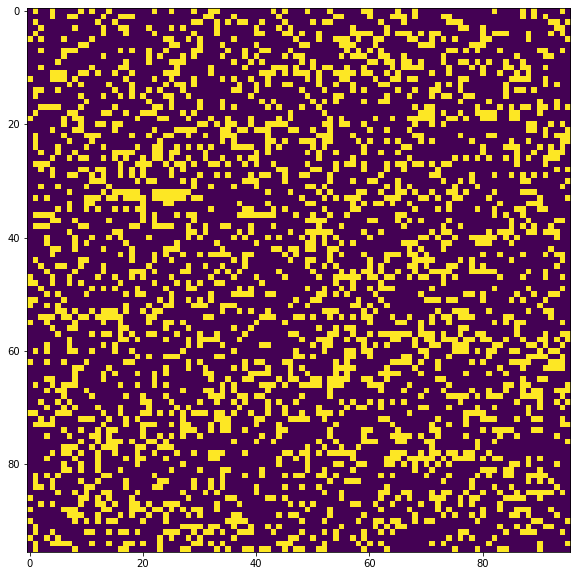

In [29]:
for t in tiles:
    if set(t.neighbors.keys()) == set(['right', 'bottom']):
        start = t

size = int(len(tiles)**0.5)
for t in tiles:
    t.remove_edge()

grid = []
el = start
for i in range(size):
    grid.append([el])
    el2 = el
    for j in range(size - 1):
        el2 = el2.neighbors['right']
        grid[i].append(el2)
    if 'bottom' in el.neighbors:
        el = el.neighbors['bottom']

ims = []
for row in range(size):
    im = grid[row][0].data
    for col in range(1, size):
        im = np.append(im, grid[row][col].data, axis=1)
    ims.append(im)
data = ims[0]
for row in range(1, size):
    data = np.append(data, ims[row], axis=0)
plt.figure(figsize = (10,10))
imshow(data)


In [30]:
def parse_monster(m):
    monster = np.array([[1 if el == '#' else 0 for el in l] for l in m.splitlines()])
    h = monster.shape[0]
    w = monster.shape[1]
    should_match = [(r,c) for r,c in product(range(h), range(w)) if monster[r][c] == 1]
    return h,w,should_match
m_height, m_width, should_match = parse_monster("""                  # 
#    ##    ##    ###
 #  #  #  #  #  #   """)


In [31]:
def is_monster(r,c,data):
    snippet = data[r:r+m_height,c:c+m_width]
    if all(snippet[m] == 1 for m in should_match):
        #print("found!")
        return True
    return False

In [32]:
def paint_monster(r,c,data):
    for m_r, m_c in should_match:
        data[m_r+r][m_c+c] = 2

In [33]:
def check_for_monsters(data):
    for r in range(data.shape[0]):
        for c in range(data.shape[1]):
            try:
                if is_monster(r,c, data):
                    return True
            except IndexError:
                break
    return False

def paint_all_monsters(data):
    for r in range(data.shape[0]):
        for c in range(data.shape[1]):
            try:
                if is_monster(r,c, data):
                    paint_monster(r,c, data)
            except IndexError:
                break

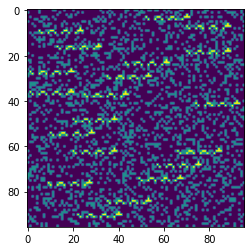

In [34]:
for i in range(8):
    data = np.rot90(data, k=i)
    if i == 4:
        data = np.fliplr(data)
    if check_for_monsters(data):
        paint_all_monsters(data)
        break
imshow(data)

In [35]:
unique, counts = np.unique(data, return_counts=True)
res = dict(zip(unique, counts))
if 2 not in res:
    print('oh no')
else:
    print(res[1])

2173
